In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn.neighbors as skn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Read the dataset
df = pd.read_csv('dataset.csv')

# Print the first 5 rows of the dataframe.
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploratory Data Analysis (EDA)

In [3]:
# Checking for null values
print(f'Null values:\n{df.isnull().sum()}')


Null values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [4]:
# Drop useless columns
df.drop(['Ticket', 'Cabin', 'Name', 'PassengerId'], axis=1, inplace=True)

# We have some missing ages, so we will fill them with the mean age
df['Age'].fillna(df['Age'].mean(), inplace=True)

# We have some missing Embarked, so we will fill them with the most common Embarked
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Print the first 5 rows of the dataframe.
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Removed 20 outliers


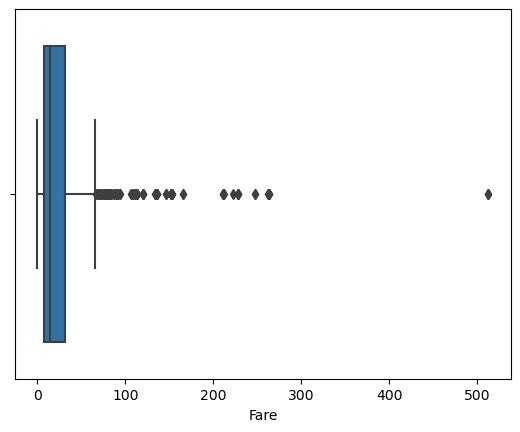

In [5]:
# Box and whisker plot for Fare to see if there are any outliers
sns.boxplot(x=df['Fare'])

lengthOfOldDf = len(df)

# Remove outliers using 3 standard deviations
df = df[np.abs(df["Fare"] - df["Fare"].mean()) <= (3 * df["Fare"].std())]
df.head()

print(f'Removed {lengthOfOldDf - len(df)} outliers')


Removed 7 outliers


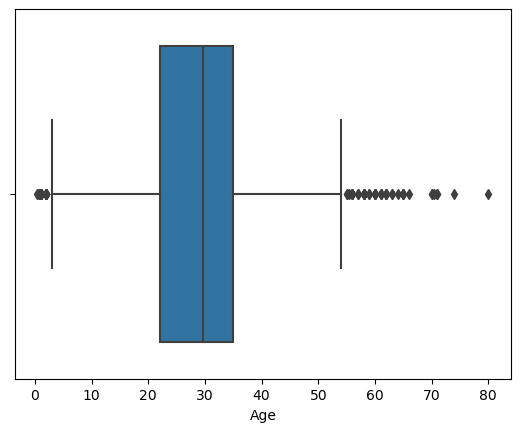

In [6]:
# Box and whisker plot for Age to see if there are any outliers
sns.boxplot(x=df['Age'])

lengthOfOldDf = len(df)

# Remove outliers using 3 standard deviations
df = df[np.abs(df["Age"] - df["Age"].mean()) <= (3 * df["Age"].std())]
df.head()

print(f'Removed {lengthOfOldDf - len(df)} outliers')


### Exploring Socio-Economic Status of Passengers

In [7]:
# Classify the socio-economic status of the passengers using the Pclass column
df['Socio-Economic Status'] = np.where(df['Pclass'] == 1, 'Upper Class',
                                       np.where(df['Pclass'] == 2, 'Middle Class', 'Lower Class'))

# Create a pivot table to summarize the relationship between socio-economic status and other features
pivot_table = pd.pivot_table(df, values=['Survived', 'Age', 'SibSp', 'Parch'], index=['Socio-Economic Status'],
                             aggfunc={'Survived': np.mean, 'Age': np.mean, 'SibSp': np.mean, 'Parch': np.mean})

# Rename SibSp and Parch columns to make it more readable
pivot_table.rename(columns={'SibSp': 'Average Siblings/Spouses Aboard',
                   'Parch': 'Average Parents/Children Aboard'}, inplace=True)

# Print the pivot table
print(pivot_table)


                             Age  Average Parents/Children Aboard  \
Socio-Economic Status                                               
Lower Class            26.215746                         0.394683   
Middle Class           29.647652                         0.382514   
Upper Class            36.927059                         0.286458   

                       Average Siblings/Spouses Aboard  Survived  
Socio-Economic Status                                             
Lower Class                                   0.617587  0.243354  
Middle Class                                  0.404372  0.475410  
Upper Class                                   0.385417  0.630208  


In this pivot table I have used the class of ticket to determine the socioeconomic status of the passengers. The class of ticket is a good indicator of the socioeconomic status of the passengers. The lower the class of ticket, the higher the socioeconomic status of the passenger. It appears that upper class socioeconomic status did correlate with survival rate. The survival rate of the upper class was 63.02% while the survival rate of the lower class was 24.33%. This is a significant difference. It is interesting to me that socioeconomic status also inversely correlated with family members aboard. Lower class individuals tended to have their siblings and spouses with them at nearly double the rate of upper class individuals.

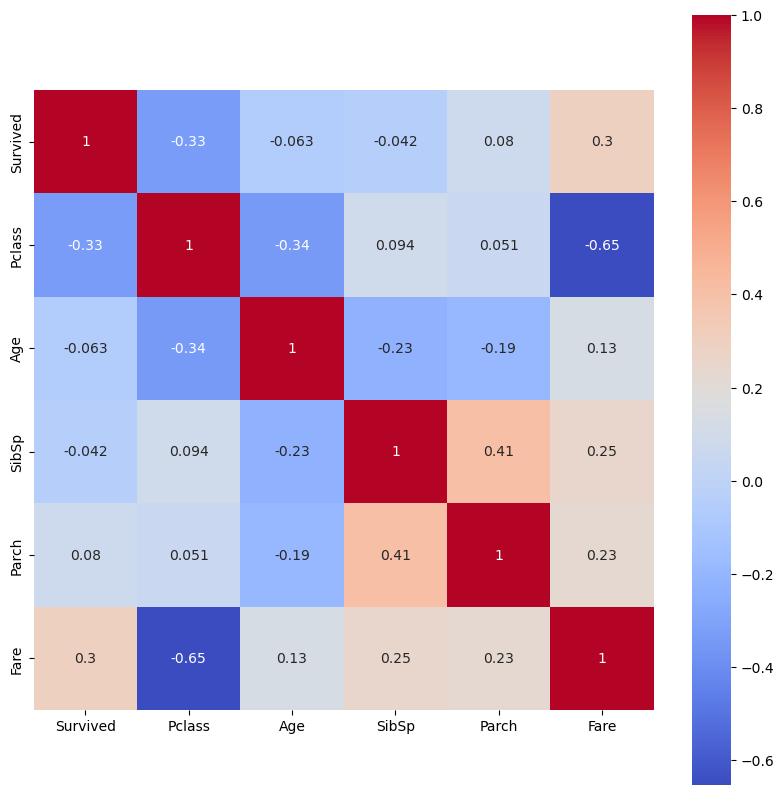

In [8]:
# Perform a correlation matrix
corr = df.corr(method='pearson')

# Plot the correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, square=True, cmap='coolwarm')
plt.show()


As we look at this correlation heatmap, we can see how socio-economic status affected other variables. For Pclass, it seems that Age, SibSp, and Parch has some of the lowest correlations while other variables have a much higher correlation. For example, the highest correlation that we can see of Pclass is -0.65 so it is a high negative correlation between fare and Pclass. Now this makes sense as the higher the Pclass is, the lower class ticket you are buying.

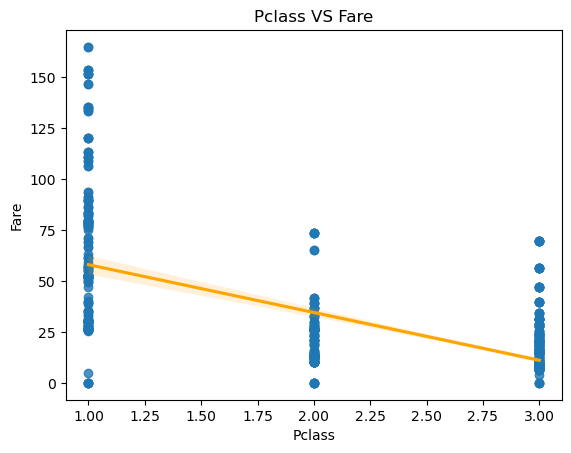

In [9]:
sns.regplot(x=df["Pclass"], y=df["Fare"], line_kws={"color": "orange"})
plt.title("Pclass VS Fare")
plt.show()


Analyzing, this graph, there seems to be a negative correlation between Pclass and Fare which shows that for the upper Pclasses, the seats are more affordable.

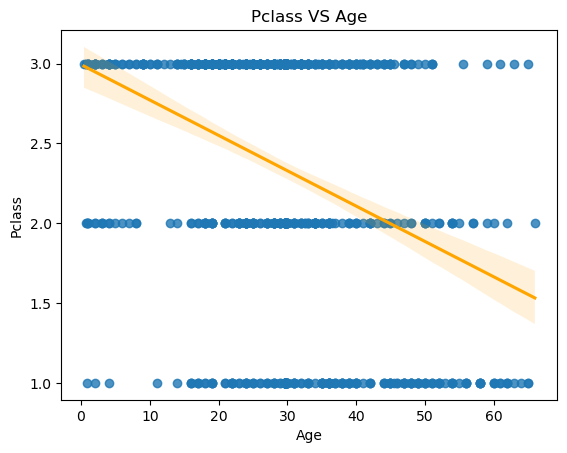

In [10]:
sns.regplot(x=df["Age"], y=df["Pclass"], line_kws={"color": "orange"})
plt.title("Pclass VS Age")
plt.show()


Analyzing, this graph, there seems to be a negative correlation here too but as the age increases, there seems to be people of lower Pclasses. This shows that people of high Pclass seem to be at lower ages while people of low Pclass seem to be at higher ages.

### Exploring Distribution of Survival Victims in Relation to Age, Gender, and Class

In [11]:
# Define a function to categorize passengers as either adult or child
def categorize_age(age):
    # I think minimum age for an adult is 19 in the UK
    if age < 19:
        return 1
    else:
        return 0


# Apply the categorize_age function to the Age column and create a new column 'Age Category'
df['Is Child'] = df['Age'].apply(categorize_age)


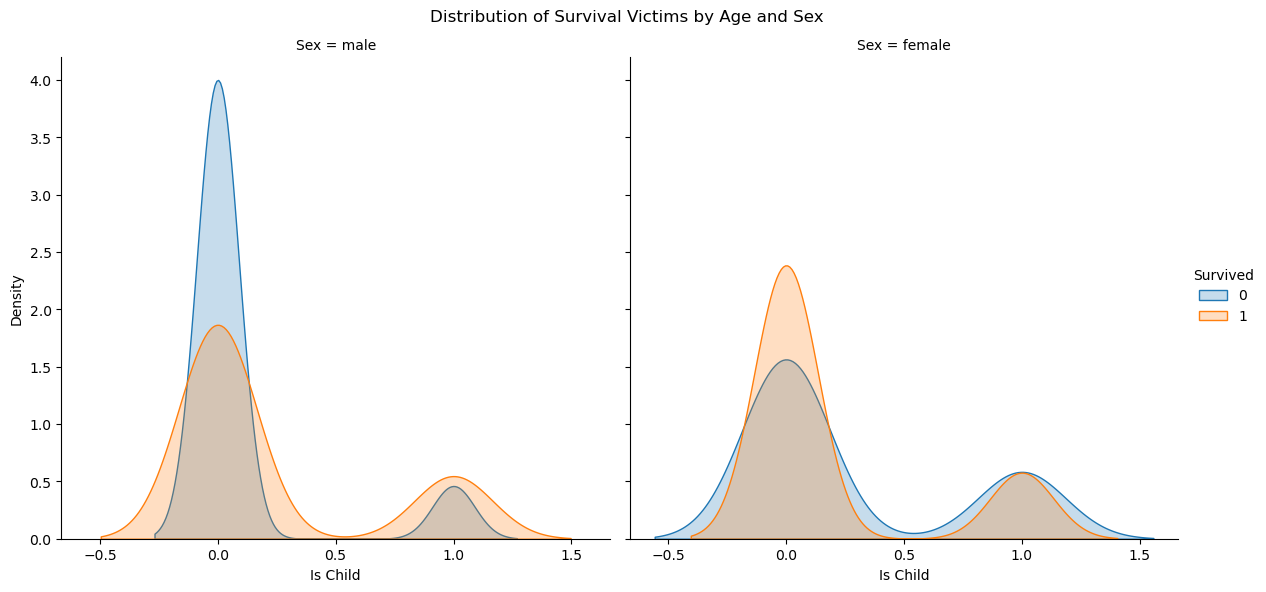

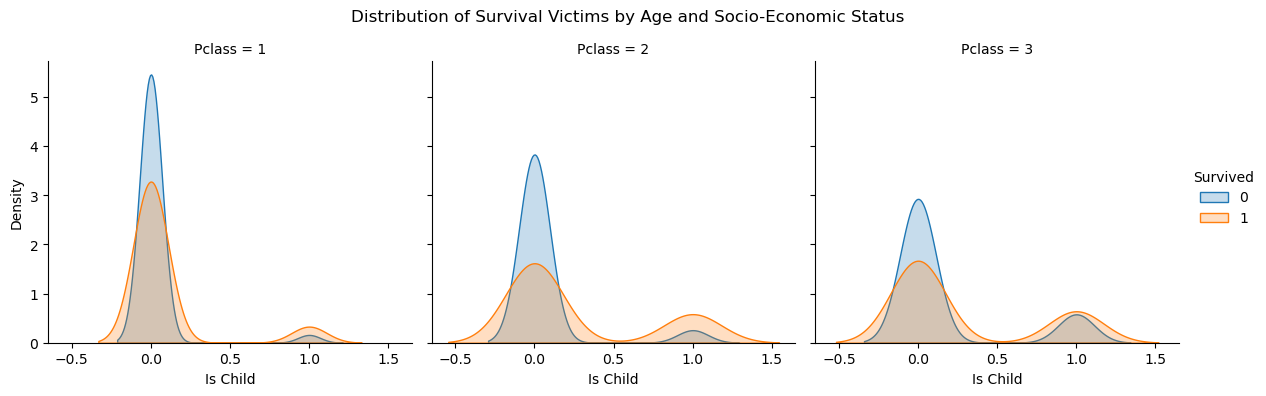

In [12]:
# Create visualizations to better understand the distribution of survival victims by age and sex
plot = sns.FacetGrid(df, col='Sex', hue='Survived', height=6)
plot.map(sns.kdeplot, 'Is Child', fill=True)
plot.add_legend()
plot.figure.suptitle('Distribution of Survival Victims by Age and Sex')
plot.figure.subplots_adjust(top=0.90)
plt.show()

# Create visualization to better understand distribution of survival victims by age and socio-economic status
plot = sns.FacetGrid(df, col='Pclass', hue='Survived', height=4)
plot.map(sns.kdeplot, 'Is Child', fill=True)
plot.add_legend()
plot.figure.suptitle('Distribution of Survival Victims by Age and Socio-Economic Status')
plot.figure.subplots_adjust(top=0.85)
plt.show()


### Extracting Information from Numerical Features

In [13]:
# Make Sex a numeric column:
# Male = 0
# Female = 1
df['Sex Factorized'] = pd.factorize(df['Sex'])[0]

# Make Embarked a numeric column
# S = 0
# C = 1
# Q = 2
df['Embarked Factorized'] = pd.factorize(df['Embarked'])[0]

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Socio-Economic Status,Is Child,Sex Factorized,Embarked Factorized
0,0,3,male,22.0,1,0,7.2500,S,Lower Class,0,0,0
1,1,1,female,38.0,1,0,71.2833,C,Upper Class,0,1,1
2,1,3,female,26.0,0,0,7.9250,S,Lower Class,0,1,0
3,1,1,female,35.0,1,0,53.1000,S,Upper Class,0,1,0
4,0,3,male,35.0,0,0,8.0500,S,Lower Class,0,0,0


Here I have used the `pandas.factorize()` method to extract information from numerical features. This method automatically assigns a numeric value to categorical features. This is useful because it allows us to use these features in our machine learning model as well as see it in our correlation matrix. I have used this method on the `Sex` and `Embarked` features. Males then are represented as 0 while females are represented as 1 for the new `Sex Factorized` column. For the `Embarked Factorized` column, Southampton (S) is represented as 0, Cherbourg (C) is represented as 1, and Queenstown (Q) is represented as 2.

### Correlation Analysis

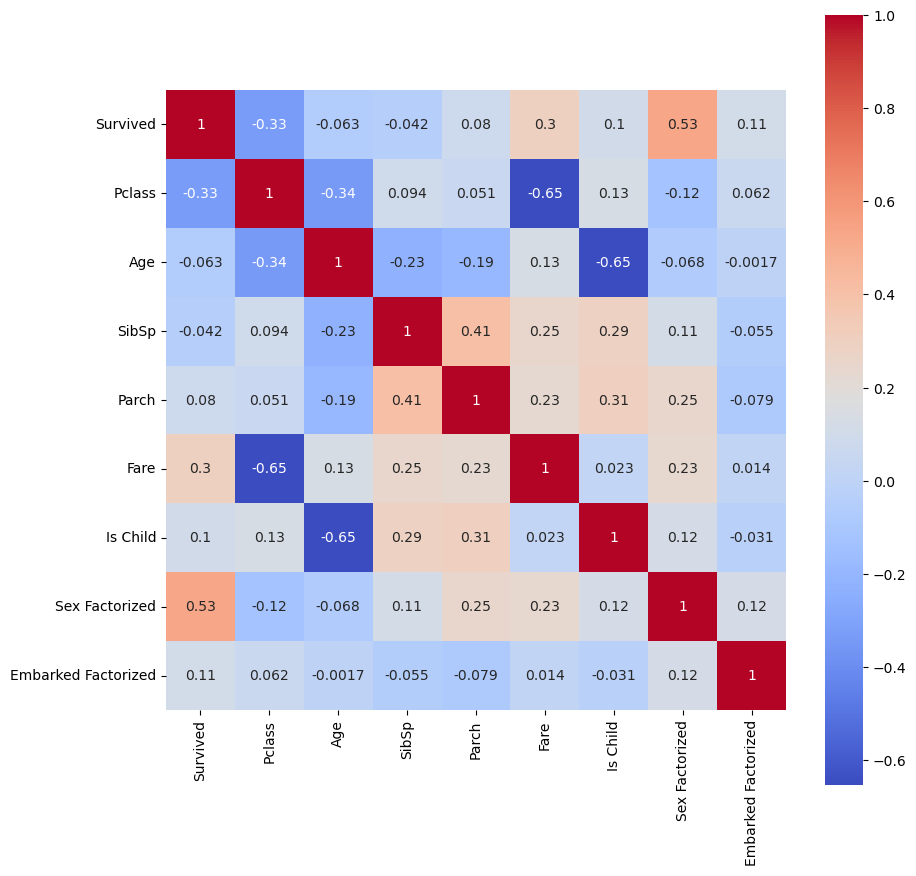

In [14]:
# Perform a correlation matrix
corr = df.corr(method='pearson')

# Plot the correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, square=True, cmap='coolwarm')
plt.show()


The correlation matrix shows the pearson correlation between the different features. The pearson correlation is a measure of the linear correlation between two variables. The correlation matrix is useful because it allows us to see which features are most correlated with each other. From this diagram it is clear that Sex and survival are very highly correlated with a 0.53 pearson coefficient. Survival also strongly negatively correlates with pclass. This makes sense as the lower pclass values refer to the higher class tickets. This means that there is a strong correlation between paying for higher class tickets and surviving as well as being a woman and surviving (woman are represented as 1 in our sex factorized column). The heatmap also shows that fare and pclass is very inversely correlated. This is to be expected as the upper class tickets should cost the most.

## Modeling and Question Answering

### Model 1 : K-Nearest Neighbors

In [15]:
X = df.drop(['Sex', 'Age', 'Embarked', 'Socio-Economic Status', 'Survived'], axis=1).copy()
y = df['Survived'].copy()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Create a KNN classifier
knn = skn.KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn.fit(X_train, y_train)

# Make predictions
predictions = knn.predict(X_test)

# Print the accuracy of the classifier
print(f'Accuracy: {accuracy_score(y_test, predictions) * 100:.02f}%')

# Print out the F1 score
print(f'F1 Score: {f1_score(y_test, predictions) * 100:.02f}%')

# Print out the classification report
print(f'Classification Report:\n{classification_report(y_test, predictions)}')


Accuracy: 77.46%
F1 Score: 71.11%
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.85      0.82       101
           1       0.76      0.67      0.71        72

    accuracy                           0.77       173
   macro avg       0.77      0.76      0.76       173
weighted avg       0.77      0.77      0.77       173



The K-Nearest Neighbors (KNN) algorithm is a non-parametric method used for classification. In KNN classification, the output is a label. An object is classified by a majority vote of its neighbors, with the object being assigned to the label most common among its k nearest neighbors (k is a positive integer, typically small). We have used this model to predict the survival of passengers on the Titanic. The model's accuracy is 77.46% with the F1 score being 71.11%. This is a good score as the model is able to predict the survival with a high accuracy and also does not falter with rare events as the F1 score is high.

In [16]:
# We want to use 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=69)

# Create a KNN classifier
knn = skn.KNeighborsClassifier(n_neighbors=5)

# Create a list to store the accuracy scores
scores = []

for train_index, test_index in kf.split(X):
    # Get the training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the classifier
    knn.fit(X_train, y_train)

    # Make predictions
    predictions = knn.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)

    f1 = f1_score(y_test, predictions)

    appendedTuple = (accuracy, f1)

    # Add the accuracy score to the list
    scores.append(appendedTuple)

# Print the average accuracy score
print(f'Average Accuracy: {np.mean(scores, axis=0)[0] * 100:.02f}%')

# Print the average F1 score
print(f'Average F1 Score: {np.mean(scores, axis=0)[1] * 100:.02f}%')


Average Accuracy: 74.99%
Average F1 Score: 65.97%


Implementing K-Folds Cross Validation with K-Nearest Neighbors does not seem to improve the performance on the test set. It actually decreased it as both the accuracy and the F1 score seemed to drop on average. This makes me think that it's not forming the clusters correctly and is not generalizing well to the test set.

### Model 2 : Logistic regression model (Predicts Survival)

In [17]:
X = df.drop(['Survived', 'Embarked', 'Socio-Economic Status', 'Is Child', 'Embarked Factorized', 'Sex'], axis=1)
y = df['Survived'].copy()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Create a logistic regression object
logreg = LogisticRegression()

# Fit the model on the training data
logreg.fit(X_train, y_train)

# Predict the target values on the test data
predictions = logreg.predict(X_test)

# Print the accuracy score of the model
print(f'Accuracy: {accuracy_score(y_test, predictions) * 100:.02f}%')
print(f'F1 Score: {f1_score(y_test, predictions) * 100:.02f}%')
print(f'Classification Report:\n{classification_report(y_test, predictions)}')


Accuracy: 83.24%
F1 Score: 78.83%
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       101
           1       0.83      0.75      0.79        72

    accuracy                           0.83       173
   macro avg       0.83      0.82      0.82       173
weighted avg       0.83      0.83      0.83       173



Logistic Regression is a regression model based on supervised learning. It is mainly used for binary classification problems. In this case, we are using logistic regression to determine whether a person survives or not. We have gotten better results than our K-Nearest Neighbors Model with an accuracy of 83.24% and an F1 Score of 78.83%. Both the accuracy and F1 score are higher which makes this an objectively better model.

In [18]:
# We want to use 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=69)

# Create a logistic regression object
logreg = LogisticRegression()

# Create a list to store the accuracy scores
scores = []

for train_index, test_index in kf.split(X):
    # Get the training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the classifier
    logreg.fit(X_train, y_train)

    # Make predictions
    predictions = logreg.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)

    f1 = f1_score(y_test, predictions)

    appendedTuple = (accuracy, f1)

    # Add the accuracy score to the list
    scores.append(appendedTuple)

# Print the average accuracy score
print(f'Average Accuracy: {np.mean(scores, axis=0)[0] * 100:.02f}%')

# Print the average F1 score
print(f'Average F1 Score: {np.mean(scores, axis=0)[1] * 100:.02f}%')


Average Accuracy: 79.16%
Average F1 Score: 71.31%


Similar to the K-Nearest Neighbors model, the K-Fold Cross Validation does not seem to improve the performance on the test set. It actually decreased it as both the accuracy and the F1 score seemed to drop on average. This makes me think that it is simply not training on enough data. Interestingly, this still performs roughly as well as the earlier K-Nearest Neighbors model if not better.

### Model 3 : K-Nearest Neighbors (Predicts Embarked Location)

In [19]:
X = df.drop(['Pclass', 'Survived', 'Embarked', 'Socio-Economic Status', 'Is Child',
            'Sex Factorized', 'Embarked Factorized', 'Sex'], axis=1)
y = df['Embarked Factorized']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Create a KNN classifier
knn = skn.KNeighborsClassifier(n_neighbors=5)

# Fit the model on the training data
knn.fit(X_train, y_train)

# Predict the target values on the test data
predictions = knn.predict(X_test)

# Print the accuracy score of the model
print(f'Accuracy: {accuracy_score(y_test, predictions) * 100:.02f}%')
print(f'F1 Score: {f1_score(y_test, predictions, average="weighted") * 100:.02f}%')
print(f'Classification Report:\n{classification_report(y_test, predictions)}')


Accuracy: 79.77%
F1 Score: 78.33%
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       133
           1       0.45      0.31      0.37        29
           2       0.78      0.64      0.70        11

    accuracy                           0.80       173
   macro avg       0.69      0.62      0.65       173
weighted avg       0.78      0.80      0.78       173



The K-Nearest Neighbors (KNN) algorithm is a non-parametric method used for classification. In KNN classification, the output is a label. An object is classified by a majority vote of its neighbors, with the object being assigned to the label most common among its k nearest neighbors (k is a positive integer, typically small). We have used this model to predict the embarked location of the passengers. This model has a good accuracy and F1 score with them both being roughly 80%. This is a good score as the model is able to predict the embarked location with a high accuracy and also does not falter with rare events as the F1 score is high.

In [20]:
# We want to use 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=69)

# Create a KNN classifier
knn = skn.KNeighborsClassifier(n_neighbors=5)

# Create a list to store the accuracy scores
scores = []

for train_index, test_index in kf.split(X):
    # Get the training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the classifier
    knn.fit(X_train, y_train)

    # Make predictions
    predictions = knn.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)

    f1 = f1_score(y_test, predictions, average='micro')

    appendedTuple = (accuracy, f1)

    # Add the accuracy score to the list
    scores.append(appendedTuple)

# Print the average accuracy score
print(f'Average Accuracy: {np.mean(scores, axis=0)[0] * 100:.02f}%')

# Print the average F1 score
print(f'Average F1 Score: {np.mean(scores, axis=0)[1] * 100:.02f}%')


Average Accuracy: 77.31%
Average F1 Score: 77.31%


Once again the use of K-Folds Cross Validation results in a lower accuracy and F1 score. This makes me think that it's not forming the clusters correctly and is not generalizing well to the test set. It is interesting that K-Folds Cross-validation resulted in a worse accuracy and F1 score for each model. This may be due too K being too high and thus the model is not generalizing well to the test set.